In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
Session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Use the Inspector to explore the database and print the table names ... same as base.classes.keys
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# List columns on each table
inspector = inspect(engine)

meas_columns = inspector.get_columns("measurement")
print("Measurement")
for column in meas_columns:
    print(column["name"], column["type"])

print("\n")
    
station_columns = inspector.get_columns("station")
print("Stations")
for column in station_columns:
    print(column["name"], column["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
most_recent_date = Session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Most recent date is: {most_recent_date[0]}")

Most recent date is: 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")
                                
# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
Retrieve_Measurement_Columns = (Measurement.date, Measurement.prcp)

Precipitation_data = Session.query(*Retrieve_Measurement_Columns).filter(Measurement.date >= start_date).all()
Precipitation_data[:5]

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01)]

In [13]:
# Save the query results as a Pandas DataFrame
Precipitation_df = pd.DataFrame(Precipitation_data, columns=["Measurement_Date", "Precipitation_Amount"])

# Set the index to the date column
Precipitation_df.set_index("Measurement_Date", inplace=True)

# Sort by Data
Precipitation_df.sort_values(by="Measurement_Date")

# Remove rows with NA values
Precipitation_df.dropna(axis=0, how="any", inplace= True)

# Print
Precipitation_df.head()

,Precipitation_Amount
Measurement_Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


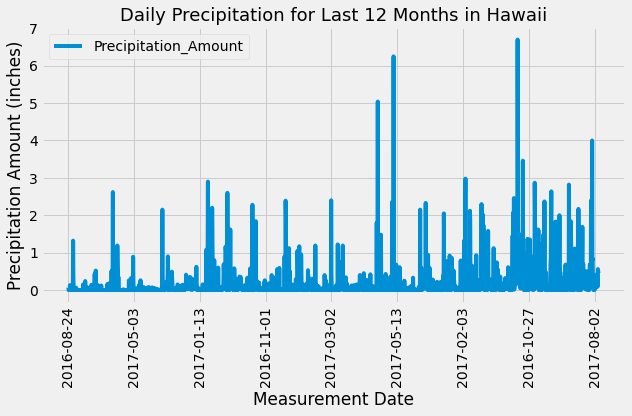

In [37]:
# Plotting Measurement_Date vs. Precipitation_Amount
Precipitation_df.plot(rot=90, figsize=(9,6))

plt.title("Daily Precipitation for Last 12 Months in Hawaii", fontsize=18)
plt.xlabel("Measurement Date")
plt.ylabel("Precipitation Amount (inches)")

plt.tight_layout()
plt.savefig("Daily_Precipitation_for_12Months_Hawaii.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_df.describe()
# Format Dataframe
Precipitation_df.describe().style.format({"Precipitation_Amount": "{:.3f}"})

,Precipitation_Amount
count,2015.000
mean,0.176
std,0.460
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset

Total_Stations = Session.query(Station.station).count()
print(f"The total number stations is: {Total_Stations}")

The total number stations is: 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active_stations =  Session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_lowest_temp =  Session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_stations[0][0]).scalar()
most_active_lowest_temp

most_active_highest_temp =  Session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_stations[0][0]).scalar()
most_active_highest_temp

most_active_average_temp =  Session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_stations[0][0]).scalar()
most_active_average_temp
          
print(f"Lowest temperature of most active station id=USC00519281: {most_active_lowest_temp} degrees Fahrenheit.")
print(f"Highest temperature of most active station id=USC00519281: {most_active_highest_temp} degrees Fahrenheit.")
print(f"Average temperature of most active station id=USC00519281: {round(most_active_average_temp, 2)} degrees Fahrenheit.")

Lowest temperature of most active station id=USC00519281: 54.0 degrees Fahrenheit.
Highest temperature of most active station id=USC00519281: 85.0 degrees Fahrenheit.
Average temperature of most active station id=USC00519281: 71.66 degrees Fahrenheit.


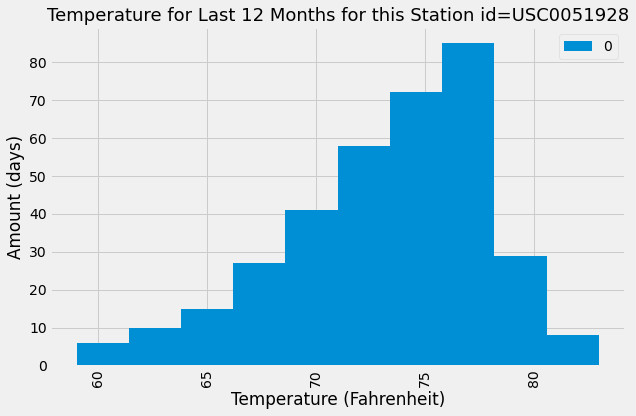

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_temp = pd.DataFrame(Session.query(Measurement.tobs).\
                                filter((Measurement.station == most_active_stations[0][0])\
                                       & (Measurement.date >= start_date)\
                                       & (Measurement.date <= end_date)).all())

most_active_temp.plot(kind="hist", rot=90, figsize=(9,6))

plt.title("Temperature for Last 12 Months for this Station id=USC0051928", fontsize=18)
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Amount (days)")

plt.tight_layout()
plt.savefig("Daily_Temperature_for_12Months_Station.png")
plt.show()

# Close session

In [43]:
# Close Session
Session.close()